/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


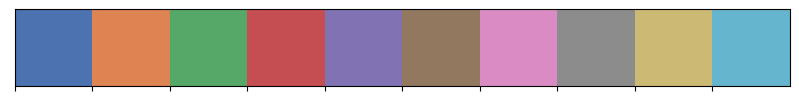

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
def read_pkl_data(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [3]:
def read_pkl_data_for_dict(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    param_mean_raw = []
    param_true = []
    for idx in data_dict.keys():
        # param_mean_raw.append(data_dict[idx]['param_mean'][None])
        param_mean_raw.append((data_dict[idx]['particles'] * data_dict[idx]['particle_weights'][:,None,:]).sum(axis=-1)[None])
        param_true.append(data_dict[idx]['param_true'][None])
    max_len = max([p.shape[1] for p in param_mean_raw])
    param_mean = []
    for p in param_mean_raw:
        if p.shape[0] < max_len:
            param_mean.append(np.concatenate([p, np.repeat(p[:,-1,None,:], max_len-p.shape[1], axis=1)], axis=1))
        else:
            param_mean.append(p)
    param_mean = np.vstack(param_mean)
    param_true = np.vstack(param_true)
    loss_abs = np.abs(param_mean - param_true[:,None,:])
    loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])
    # loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    # loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [4]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2, 0.4]
datadir = 'benchmarks'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [5]:
# for pw in tqdm(pw_list):
#     for nl in noise_level_list:
#         fname_lst = [
#             os.path.join(datadir, f'{run}/bayesian_{task}_pw-{pw}_nl-{nl}_Nb-{Nb:d}.pkl') for task in task_labels for run in run_labels
#         ]
#         # print('\n'.join(fname_lst))
#         loss_abs = [read_pkl_data_for_dict(f)[0] for f in fname_lst]
#         # loss_rel = [read_pkl_data_for_dict(f)[1] for f in fname_lst]
#         loss = torch.tensor(np.asarray(loss_abs))
#         loss_exp_mean = torch_scatter.scatter_mean(loss, scatter_mean_indices, dim=0)
#         loss_mean = loss_exp_mean.mean(dim=1)
#         loss_std = torch_scatter.scatter_std(loss, scatter_mean_indices, dim=0).mean(dim=1)
#         results[(pw, nl)] = {
#             "loss_mean": loss_mean,
#             "loss_std": loss_std
#         }
# torch.save(results, "benchmarks/summarized_results.pt")

In [6]:
results = torch.load("benchmarks/summarized_results.pt")

In [7]:
results.keys()

dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0), (0.4, 0.5), (0.4, 1.0), (0.4, 2.0)])

In [8]:
%load_ext autoreload
%autoreload 2

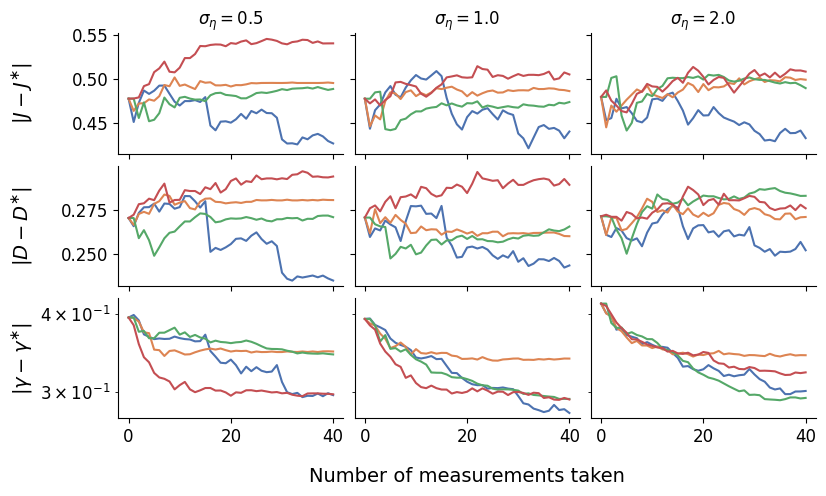

In [11]:
ylabels = ['J', 'D', '\gamma']
legends = ['Bayesian w. MLE', 'Bayesian', 'Sequential', 'Random']
import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(9,9))
# gs = fig.add_gridspec(3,3)
fig, axes = plt.subplots(nrows=3, ncols=3, sharex='col', sharey='row', figsize=(9, 5), gridspec_kw={"wspace": 0.05, "hspace": 0.1})
# for i_pw, pw in tqdm(enumerate(pw_list[:1])):

i_pw = 2
pw = pw_list[i_pw]
for i_nl, nl in enumerate(noise_level_list):
    # ax = fig.add_subplot(gs[i_pw, i_nl])
    loss_mean = results[(pw,nl)]['loss_mean']
    for i_ax in range(3):
        ax = fig.add_subplot(axes[i_ax, i_nl])
        if i_nl == 0:
            ax.set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$')
        if i_ax == 2 and i_nl == 1:
            ax.set_xlabel("Number of measurements taken", labelpad=15)
        if i_ax == 0:
            ax.set_title(rf"$\sigma_{{\eta}}={nl:.1f}$")
    # axes_inner = gridspec.GridSpecFromSubplotSpec(3, 1,
    #                 subplot_spec=axes[i_pw, i_nl], wspace=0.1, hspace=0.1)
    # axes[i_pw, i_nl].set_xticks([])
    # axes[i_pw, i_nl].set_yticks([])
        # ax = fig.add_subplot(axes_inner[i_ax])
        for j, _mean in enumerate(loss_mean):
            if i_ax == 2:
                ax.semilogy(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[j], label=legends[j])
            else:
                ax.plot(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[j], label=legends[j])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.set_yscale('linear')
            # if i_ax == 2:
            #     ax.set_yscale('log')
        # else:
        #     ax.set_yscale('linear')
        if i_pw == 3 and i_ax == 2 and i_nl == 2:
            ax.legend(loc='center left', bbox_to_anchor=(-2, -1), ncols=4)

fig.align_ylabels(axes[:,0])
plt.show()
# fig.savefig(f"figures/benchmarks/pw-{pw}_Nb-{Nb:d}.pdf", bbox_inches='tight')

NameError: name 'noise_level' is not defined

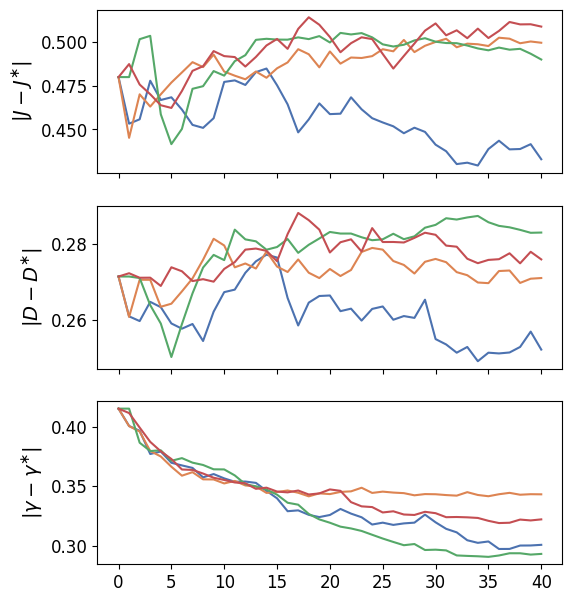

In [16]:
ylabels = ['J', 'D', '\gamma']
legends = ['Bayesian w. MLE', 'Bayesian', 'Sequential', 'Random']
fig, ax = plt.subplots(3, 1, figsize=(6,7.2), sharex=True)
for i_ax in range(3):
    for i, (_mean, _std) in enumerate(zip(loss_mean, loss_std)):
        ax[i_ax].plot(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[i], label=legends[i])
        # ax[i_ax].fill_between(np.arange(_mean.shape[0]), _mean[...,i_ax]-_std[...,i_ax], _mean[...,i_ax]+_std[...,i_ax], alpha=0.25)
    ax[i_ax].set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$')
ax[0].set_title(f"Pulse width: {pw} ps, noise level: {noise_level}")
ax[-1].set_xlabel('Number of measurements')
ax[-1].legend()
ax[-1].set_yscale('log')
fig.tight_layout()
# fig.savefig(f"figures/benchmarks/pw-{pw}_nl-{noise_level}_Nb-{Nb:d}.pdf", bbox_inches='tight')

IndexError: list index out of range

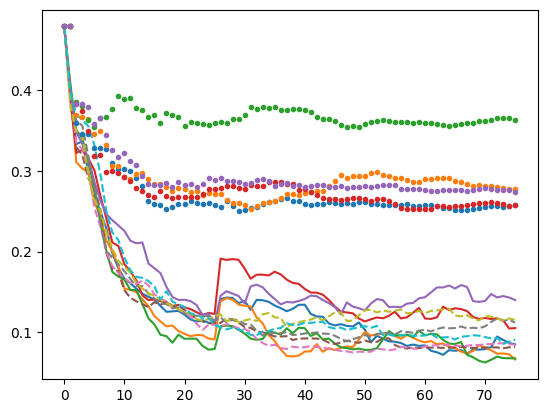

In [85]:
idx = 0
linestyles = ['-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '.', '.', '.', '.', '.']
# linestyles = ['-', '-', '--', '--', '.', '.']
fig, ax = plt.subplots(1, 1)
for i, _loss in enumerate(loss_info_lst):
    ax.plot(np.arange(_loss.shape[1]), _loss.mean(axis=0)[:,idx], linestyles[i])
    # ax.fill_between(np.arange(loss.shape[1]), 
    #     loss.mean(axis=0)[:,idx]-0.05*loss.std(axis=0)[:,idx],
    #     loss.mean(axis=0)[:,idx]+0.05*loss.std(axis=0)[:,idx], alpha=0.25)

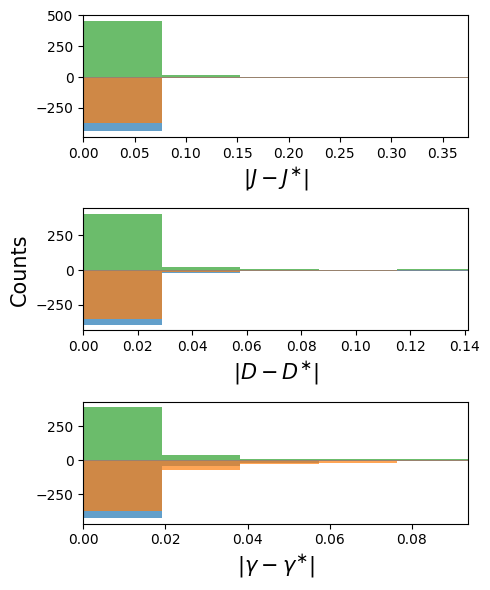

In [22]:
i_iter = -1

xlabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(3, 1, figsize=(5,6))
for i_ax in range(3):
    bins = np.linspace(0, loss[...,i_ax].max(), 50)
    for i_param in range(3):
        data = torch.cat(torch.unbind(loss[index==i_param], dim=0)).numpy()
        counts, bins = np.histogram(data[:,i_iter,i_ax], bins=bins)
        if i_param == 2:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, counts, width=bins[1]-bins[0], alpha=0.7)
        else:
            ax[i_ax].bar((bins[:-1]+bins[1:])/2, -counts, width=bins[1]-bins[0], alpha=0.7)
        # ax[i_ax].set_yscale('log')
    ax[i_ax].hlines(0, -10, 10, colors='gray', linestyles='-', linewidth=0.5)
    ax[i_ax].set_xlabel(rf'$|{xlabels[i_ax]}-{xlabels[i_ax]}^{{\ast}}|$', fontsize=15)
    ax[i_ax].set_xlim([0, 0.1 * loss[...,i_ax].max()])
    # ax[i_ax].set_yticks([-300,  0, 300])
    if i_ax == 1:
        ax[i_ax].set_ylabel('Counts', fontsize=15)
    # ax[i_ax].set_yticklabels(['-500', '0', '500'])
fig.tight_layout()
# fig.savefig(f"figs/paper/comparisons/hist_pw-{pw}_nl-{noise_level}_Nb-200.pdf", bbox_inches='tight')

(-1.0, 3.0)

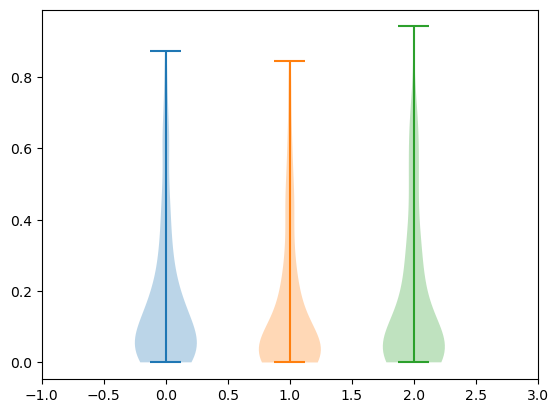

In [6]:
import seaborn as sns

idx = 1
iter_num = 10

fig = plt.figure()
ax = fig.add_subplot()
ax.violinplot(loss_info_lst[0][:,iter_num,idx], positions=[0])
ax.violinplot(loss_info_lst[4][:,iter_num,idx], positions=[1])
ax.violinplot(loss_info_lst[-1][:,iter_num,idx], positions=[2])
# sns.swarmplot(x=0*np.ones_like(loss_info_lst[0][:,iter_num,idx]), y=loss_info_lst[0][:,iter_num,idx], orient='v')
# sns.swarmplot(x=1*np.ones_like(loss_info_lst[4][:,iter_num,idx]), y=loss_info_lst[4][:,iter_num,idx], orient='v')
# sns.swarmplot(x=2*np.ones_like(loss_info_lst[-1][:,iter_num,idx]), y=loss_info_lst[-1][:,iter_num,idx], orient='v')
ax.set_xlim([-1, 3])
# ax.set_yscale('log')

In [7]:
with open('{datadir}/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    baseline_dict = pickle.load(f)
# with open('{datadir}/bayesian_baseline_pw-0.1_nl-10.0_Nb-200.pkl', 'rb') as f:
#     baseline_dict_nl10 = pickle.load(f)
with open('{datadir}/bayesian_random_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    random_dict = pickle.load(f)
with open('{datadir}/bayesian_gradientdesc_pw-0.1_nl-5.0_Nb-200.pkl', 'rb') as f:
    gd_dict = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/benchmark/bayesian_baseline_pw-0.1_nl-5.0_Nb-200.pkl'

In [ ]:
l1_diff_baseline = np.abs(baseline_dict['param_mean'] - baseline_dict['param_true'][:,None,:])
# l1_diff_baseline_nl10 = np.abs(baseline_dict_nl10['param_mean'] - baseline_dict_nl10['param_true'][:,None,:])
l1_diff_random = np.abs(random_dict['param_mean'] - random_dict['param_true'][:,None,:])
l1_diff_gd = np.abs(gd_dict['param_mean'] - gd_dict['param_true'][:,None,:])

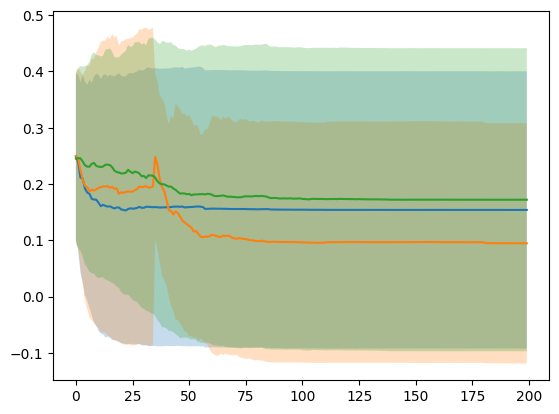

In [ ]:
idx = 1

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(l1_diff_baseline.shape[1]), l1_diff_baseline.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_baseline.shape[1]), 
    l1_diff_baseline.mean(axis=0)[:,idx]-l1_diff_baseline.std(axis=0)[:,idx],
    l1_diff_baseline.mean(axis=0)[:,idx]+l1_diff_baseline.std(axis=0)[:,idx], alpha=0.25)

# ax.plot(np.arange(l1_diff_baseline_nl10.shape[1]), l1_diff_baseline_nl10.mean(axis=0)[:,idx])
# ax.fill_between(np.arange(l1_diff_baseline_nl10.shape[1]), 
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]-l1_diff_baseline_nl10.std(axis=0)[:,idx],
#     l1_diff_baseline_nl10.mean(axis=0)[:,idx]+l1_diff_baseline_nl10.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_gd.shape[1]), l1_diff_gd.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_gd.shape[1]), 
    l1_diff_gd.mean(axis=0)[:,idx]-l1_diff_gd.std(axis=0)[:,idx],
    l1_diff_gd.mean(axis=0)[:,idx]+l1_diff_gd.std(axis=0)[:,idx], alpha=0.25)

ax.plot(np.arange(l1_diff_random.shape[1]), l1_diff_random.mean(axis=0)[:,idx])
ax.fill_between(np.arange(l1_diff_random.shape[1]), 
    l1_diff_random.mean(axis=0)[:,idx]-l1_diff_random.std(axis=0)[:,idx],
    l1_diff_random.mean(axis=0)[:,idx]+l1_diff_random.std(axis=0)[:,idx], alpha=0.25)